In [2]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
import nifty5 as ift
import void_library as VL
import Pk_library as PKL

Next let us analyse out training process by looking at the evolution of the cost functions of the network as well as the corresponding gradients

Next plot the evolution of the gradients for the different networks

In [3]:
path_to_data = '/u/ivkos/sr/GriddedSimulationsTraining/'
path_to_sr = '/u/ivkos/sr/Output/multi_pass_no_layer_norm/'

Function to scale the datapoints into a small $\approx [0-1]$ range which is quite usefull for both training and viewing of the data. The scaling function is taken from the "HIGAN" paper. For the max mass number in the denominater we are using the maximum of the low-res simulation to be consistend with the scaling that is available when super resolving unlabeled data.

In [4]:
def scale(data, epsilon=1e-9):
    return np.log(data+epsilon)/25+1
def unscale(data, epsilon=1e-9):
    return (np.exp(25*(data-1))-epsilon)

def scale_2(data, epsilon=1e-9):
    return np.log(data+epsilon)/25
def unscale_2(data, epsilon=1e-9):
    return (np.exp(25*(data))-epsilon)

def scale_3(data, epsilon=1e-9):
    return np.log(data+epsilon)
def unscale_3(data, epsilon=1e-9):
    return (np.exp(data)-epsilon)

def scale_4(data, epsilon=1e-9):
    return np.log(data+epsilon)+25
def unscale_4(data, epsilon=1e-9):
    return (np.exp(data-25)-epsilon)

Next we define a trivial function which simply takes a slice out of a simulation oriented along some given axis. This ensures that we always take the same slice without having to change the number in each dataset.

In [5]:
def take_slice(data, axis=1, slice_num=420):
    if axis == 0:
        slice_data = np.zeros(())
        return np.copy(data[slice_num,...])
    elif axis == 1:
        return np.copy(data[:,slice_num,:])
    else:
        return np.copy(data[:,:,slice_num])

Define the paths of all the datasets you want to use with this script

In [6]:
sim256_grid512_path = path_to_data+'256_grid512.npy'
sim512_grid512_path = path_to_data+'512_grid512.npy' 
sim128_grid512_path = path_to_data+'128_grid512.npy' 
#Init_path = path_to_data + 'ics512_grid512.npy'
#TNG_path = path_to_data+'TNG455.npy'
#sr_path_first_only = path_to_sr+'multi_pass_no_layer_norm_sr_output_first_only.npy'
#sr_path_second_only = path_to_sr+'multi_pass_no_layer_norm_sr_output_second_only.npy'
#sr_path = path_to_sr+'multi_pass_no_layer_norm2_sr_output_2_runs_test.npy'

Load the datasets take a slice from them and delete them so as to save memory. Also save the max of the low-res simulation for the normalization.

In [9]:
sim = np.load(sim256_grid512_path)
sim2 = np.load(sim512_grid512_path)
sim = sim2-sim

print(np.amax(sim))
print(np.amin(sim))
print(np.average(sim))  
print(np.median(sim))
print(np.std(sim))
slice256_grid512 = take_slice(sim)

sim = np.load(sim512_grid512_path)
print(np.amax(sim))
print(np.amin(sim))
print(np.average(sim))                
slice512_grid512 = take_slice(sim)

sim = np.load(sim128_grid512_path)
print(np.amax(sim))
print(np.amin(sim))
print(np.average(sim))                
slice128_grid512 = take_slice(sim)

del sim

0.23217249
-0.2434386
3.812711e-11
-1.1698721e-06
0.00024706265
0.9679686
0.0
5.7068264e-05
1.12127
0.0
5.6807796e-05


Display the slices for visual comparison

In [ ]:
f = plt.figure(figsize=(18, 18))
f.add_subplot(2,2, 1)
plt.imshow(scale_2(slice256_grid512), label='lr')
plt.title('low resolution')

f.add_subplot(2,2, 2)
plt.imshow(scale_2(slice512_grid512))
plt.title('high resolution')

f.add_subplot(2,2, 3)
plt.imshow(scale_2(slice128_grid512), label='lr')
plt.title('very low resolution')
plt.show()

In [ ]:
def get_vsf(sim, box_size=10., radii=10/512*np.arange(5, 65, 1, dtype=np.float32)):
    # parameters of the void finder
    delta = (sim-np.average(sim))/np.average(sim)
    BoxSize    = box_size
    threshold  = -0.7
    Radii      = radii
    threads1   = 16
    threads2   = 4
    void_field = False
    Voids = VL.void_finder(delta, BoxSize, threshold, Radii, threads1, threads2, void_field=False)
    return (Voids.Rbins, Voids.void_vsf)

In [ ]:
vsf_512 = get_vsf(np.load(sim512_grid512_path))

In [ ]:
vsf_256 = get_vsf(np.load(sim256_grid512_path))

In [ ]:
vsf_128 = get_vsf(np.load(sim128_grid512_path))

In [ ]:
print(vsf_512[0])
print(vsf_512[1])

In [ ]:
plt.plot(vsf_512[0],vsf_128[1], label='128')
plt.plot(vsf_512[0],vsf_256[1], label='256')
plt.plot(vsf_512[0],vsf_512[1], label='512')
plt.legend()
plt.show()

In [ ]:
plt.plot(vsf_512[0],vsf_128[1]/vsf_512[1], label='128')
plt.plot(vsf_512[0],vsf_256[1]/vsf_512[1], label='256')
plt.plot(vsf_512[0],vsf_512[1]/vsf_512[1], label='512')
plt.xlim(0.1,0.5)
plt.ylim(0.5,1.2)
plt.legend()
plt.show()

Function that calculates the bispectrum

In [21]:
def get_bispectrum(sim, box_size=10., theta=np.linspace(0, np.pi, 25), k1=15., k2=25):
    delta = (sim-np.average(sim))/np.average(sim)
    bispec = PKL.Bk(delta, box_size, k1, k2, theta, MAS='None', threads=4)
    return (bispec.B)

In [22]:
bispec_512 = get_bispectrum(np.load(sim512_grid512_path))


Computing bispectrum of the field...
Time to compute bispectrum = 62.47


In [23]:
bispec_256 = get_bispectrum(np.load(sim512_grid512_path))


Computing bispectrum of the field...
Time to compute bispectrum = 61.75


In [24]:
bispec_128 = get_bispectrum(np.load(sim512_grid512_path))


Computing bispectrum of the field...
Time to compute bispectrum = 63.37


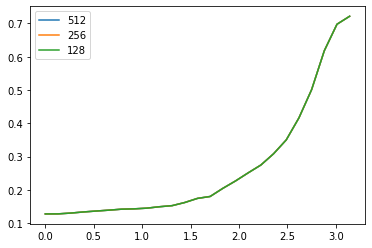

In [25]:
theta=np.linspace(0, np.pi, 25)
plt.plot(theta,bispec_512, label='512')
plt.plot(theta,bispec_256, label='256')
plt.plot(theta,bispec_128, label='128')

plt.legend()
plt.show()

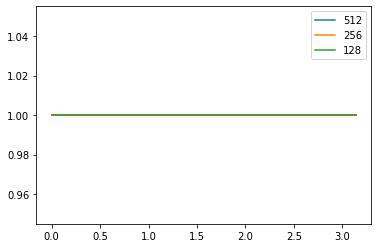

In [28]:
theta=np.linspace(0, np.pi, 25)
plt.plot(theta,bispec_512/bispec_512, label='512')
plt.plot(theta,bispec_256/bispec_512, label='256')
plt.plot(theta,bispec_128/bispec_512, label='128')

plt.legend()
plt.show()

Next comes the statistical analysis of the data samples. First we define a function which creates a logarithmic histogram of a given dataset and returns the histogram together with the middle value of a given bin.

In [26]:
def hist(data, min_value, max_value,bins=100):
    edges = np.logspace(min_value, max_value, bins+1)
    hist, _ = np.histogram(data,edges)
    midpoints = np.zeros(len(edges)-1)
    bin_widths = np.zeros(len(edges)-1)
    for i in range(len(midpoints)):
        midpoints[i] = np.power(10.,np.log10(edges[i])+np.log10(edges[i+1]/edges[i])/2)
        bin_widths[i] = edges[i+1]-edges[i]
    hist = hist/hist.sum()
    hist = hist/bin_widths
    return (midpoints, hist)

Calculate the histograms of the overdensities of the datasets

In [27]:
sim = np.load(sim512_grid512_path)
delta =  (sim)/np.average(sim)
midpoints, histogram = hist(delta, -3., 5.)
del sim

sim = np.load(sim256_grid512_path)
delta =  (sim)/np.average(sim)
midpoints256, histogram256 = hist(delta, -3., 5.)
del sim

sim = np.load(sr_path)
delta =  (sim)/np.average(sim)
midpoints_sr, histogram_sr = hist(delta, -3., 5.)
del sim

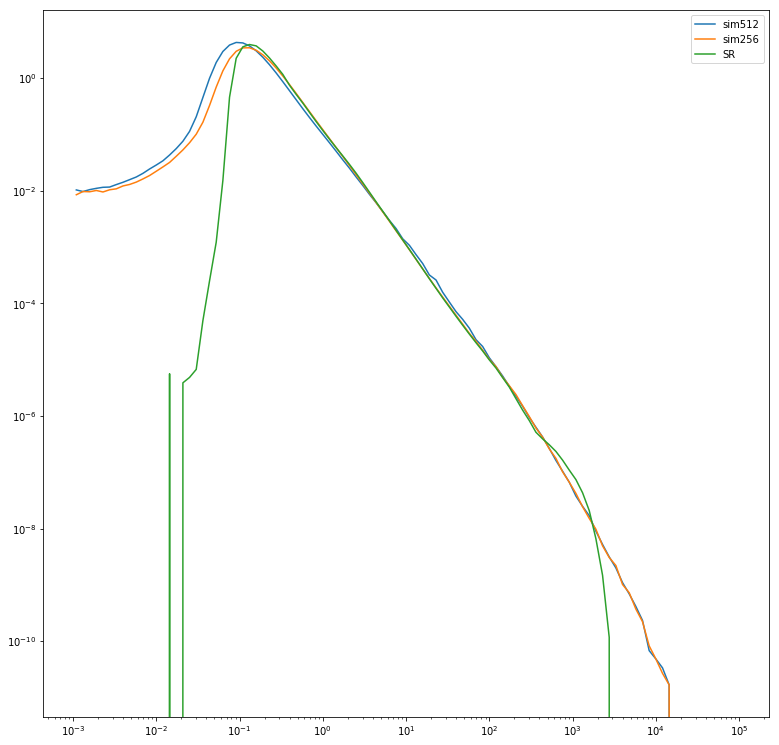

In [28]:
f = plt.figure(figsize=(13, 13))
plt.plot(midpoints, histogram, label='sim512')
plt.plot(midpoints256, histogram256, label='sim256')
plt.plot(midpoints_sr, histogram_sr, label='SR')
# plt.plot(midpointsTNG, histogramTNG, label='TNG')
# plt.plot(midpointsInit, histogramInit, label='Init')
#plt.plot(midpointsTNG, 1e-1*midpointsTNG**-2, '--', label='Fit')
#plt.ylim((1e-5,2e-1))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Next define a function which calculates the power spectrum of the density grids

In [109]:
def powerspectrum(delta,size=10, binsize=300):
    position_space = ift.RGSpace([delta.shape[0], delta.shape[1], delta.shape[2]], 
                                 distances=(size/delta.shape[0], 
                                            size/delta.shape[1], size/delta.shape[2]))
    harmonic_space = position_space.get_default_codomain()
    HT = ift.HartleyOperator(harmonic_space, position_space)
    image = ift.Field.from_global_data(position_space, delta)
    ht_image = HT.inverse(image)
    power_spec = ift.power_analyze(ht_image)
    k_values = power_spec.domain[0].k_lengths
    power_spec = ift.Field.to_global_data(power_spec)
    binned_k = []
    binned_power_spec = []
    for i in range(int(power_spec.shape[0]/binsize)):
        binned_k.append(np.average(k_values[i*binsize:(i+1)*binsize]))
        binned_power_spec.append(np.average(power_spec[i*binsize:(i+1)*binsize]))

    spectrum = np.zeros((2, len(binned_k)))
    spectrum[0, ...] = binned_k
    spectrum[1, ...] = binned_power_spec
    return (spectrum[0,...], spectrum[1,...]/size**3)

In [48]:
sim = np.load('/u/ivkos/Gridding/Output/TNG455.npy')
delta =  (sim - np.average(sim))/np.average(sim)

proj_power2, k_values2 = powerspectrum(delta, bins=100, sim_size=75)
power_TNG=np.zeros((2,proj_power2.shape[0]))
power_TNG[0,:]=k_values2
power_TNG[1,:]=proj_power2
np.save('powerspec_TNG', power_TNG)

/mpcdf/soft/SLE_12_SP4/packages/x86_64/anaconda/3/2019.03/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:600: ComplexWarning: Casting complex values to real discards the imaginary part
  result[vv, i] = statistic(values[vv, binnumbers == i])


Calculate the power spectra of the simulation boxes

In [29]:
sim = np.load(sim512_grid512_path)
delta =  (sim - np.average(sim))/np.average(sim)
del sim
proj_power, k_values = powerspectrum(delta, sim_size=10, grid_size=512)

/mpcdf/soft/SLE_12_SP4/packages/x86_64/anaconda/3/2019.03/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:600: ComplexWarning: Casting complex values to real discards the imaginary part
  result[vv, i] = statistic(values[vv, binnumbers == i])


In [30]:
sim = np.load(Init_path)
delta =  (sim - np.average(sim))/np.average(sim)
del sim
proj_power_init, k_values_init = powerspectrum(delta, sim_size=10, grid_size=512)

/mpcdf/soft/SLE_12_SP4/packages/x86_64/anaconda/3/2019.03/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:600: ComplexWarning: Casting complex values to real discards the imaginary part
  result[vv, i] = statistic(values[vv, binnumbers == i])


Load the Eisenstein Hu powerspectrum for comparison

In [31]:
EH_pow = np.loadtxt('/u/ivkos/Gridding/Output/EisensteinHuPow.txt')
k_EH = EH_pow[500:,0]
pow_EH = EH_pow[500:,2]

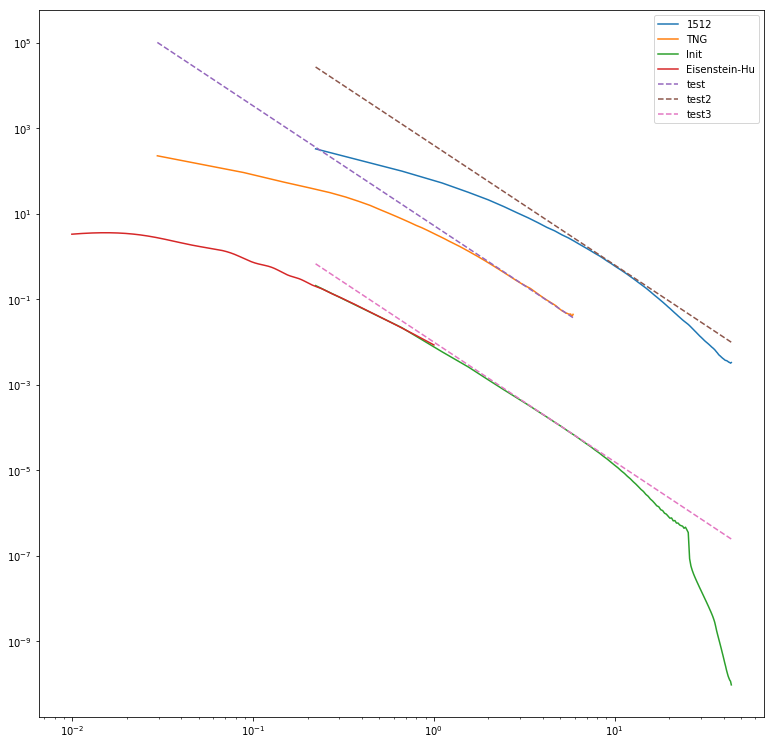

In [32]:
f = plt.figure(figsize=(13, 13))
plt.plot(k_values, proj_power/2.85e11, label='1512')
plt.plot(k_values2, proj_power2/2.85e11, label='TNG')
plt.plot(k_values_init, proj_power_init/2.85e11, label='Init')
plt.plot(k_EH, 1e2*pow_EH, label='Eisenstein-Hu')

plt.plot(k_values2, 1.5e3*np.power(k_values,-2.8),'--', label='test')
plt.plot(k_values, 4e2*np.power(k_values,-2.8),'--', label='test2')
plt.plot(k_values, 1e-2*np.power(k_values,-2.8),'--', label='test3')
#plt.xlim((2e-1,1e1))
#plt.ylim((1e9,1e12))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [154]:
sim = np.load(sim512_grid512_path)
delta =  (sim - np.average(sim))/np.average(sim)
del sim
k, proj_power_512 = powerspectrum(delta, binsize=326)

# sim = np.load(sim256_grid512_path)
# delta =  (sim - np.average(sim))/np.average(sim)
# del sim
# k, proj_power_256 = powerspectrum(delta)
print(k.shape)

(432,)


In [155]:
sim = np.load(sim512_grid512_path)
delta =  (sim - np.average(sim))/np.average(sim)
print(delta.shape)
Pk = PKL.Pk(delta, BoxSize=10., axis=0, MAS='None', threads=8)


(512, 512, 512)

Computing power spectrum of the field...
Time to complete loop = 5.16
Time taken = 5.71 seconds


In [172]:
print(Pk.k3D[12]/(2*np.pi))
print(k-Pk.k3D[11:]/(2*np.pi))

1.3481058621899464
[ 0.06151872  1.05708056  1.66915858  2.14519067  2.54267513  2.88711943
  3.19117806  3.46482502  3.71417863  3.94465244  4.15879854  4.3563805
  4.54197251  4.71646314  4.87994086  5.03532208  5.18291938  5.32317023
  5.45732183  5.58389413  5.70501716  5.82066193  5.93128178  6.03740813
  6.13899083  6.23742701  6.33181941  6.42181776  6.5088778   6.5923636
  6.67290532  6.75030481  6.82454886  6.89655716  6.96663945  7.03414536
  7.09918313  7.16152697  7.22178607  7.28015757  7.33629292  7.39068606
  7.44376625  7.49465743  7.54345699  7.59127385  7.63716493  7.6815417
  7.72389298  7.76496649  7.80506933  7.84317153  7.88057657  7.91628268
  7.95063745  7.9843108   8.0161348   8.04722578  8.07727796  8.106241
  8.13428605  8.16025705  8.18577543  8.21030983  8.23385912  8.25668642
  8.27855064  8.29951556  8.31984835  8.33893553  8.35644131  8.37349487
  8.39037282  8.40657409  8.42125611  8.43531394  8.44918959  8.46177218
  8.47342789  8.48464826  8.49525402 

In [20]:
f = plt.figure(figsize=(13, 13))
plt.plot(k, proj_power_512, label='512')
plt.plot(Pk.k3D[11:], Pk.Pk[:,0][11:], label='512 confirm')

#plt.plot(k, proj_power_256, label='256')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'k' is not defined

<Figure size 936x936 with 0 Axes>